# Introductory Examples

In [1]:
import warnings
warnings.simplefilter('ignore')

## Implied Volatilities

In [2]:
V0 = 17.6639

In [3]:
r = 0.01

In [4]:
import pandas as pd
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']  # VSTOXX futures data
options_data = h5['options_data']  # VSTOXX call option data
h5.close()

In [5]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375
501,2014-03-31,2014,9,20.95,2014-09-19,0.471
502,2014-03-31,2014,10,21.05,2014-10-17,0.548
503,2014-03-31,2014,11,21.25,2014-11-21,0.644


In [6]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [7]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31,2014-04-18,0.049,1.0,16.85
46171,2014-03-31,2014-04-18,0.049,2.0,15.85
46172,2014-03-31,2014-04-18,0.049,3.0,14.85
46173,2014-03-31,2014-04-18,0.049,4.0,13.85
46174,2014-03-31,2014-04-18,0.049,5.0,12.85


In [8]:
options_data['IMP_VOL'] = 0.0
  # new column for implied volatilities

In [9]:
from bsm_functions import *

In [10]:
tol = 0.5  # tolerance level for moneyness
for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values[0]
      # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']
                             < forward * (1 + tol)):
        # only for options with moneyness within tolerance
        imp_vol = bsm_call_imp_vol(
                V0,  # VSTOXX value 
                options_data.loc[option]['STRIKE'],
                options_data.loc[option]['TTM'],
                r,   # short rate
                options_data.loc[option]['PRICE'],
                sigma_est=2.,  # estimate for implied volatility
                it=100)
        options_data['IMP_VOL'].loc[option] = imp_vol

In [11]:
futures_data['MATURITY']
  # select the column with name MATURITY

496   2014-04-18
497   2014-05-16
498   2014-06-20
499   2014-07-18
500   2014-08-15
501   2014-09-19
502   2014-10-17
503   2014-11-21
Name: MATURITY, dtype: datetime64[ns]

In [12]:
options_data.loc[46170]
  # select data row for index 46170

DATE         2014-03-31 00:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     2014-04-18 00:00:00
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

In [13]:
options_data.loc[46170]['STRIKE']
  # select only the value in column STRIKE
  # for index 46170 

1.0

In [14]:
plot_data = options_data[options_data['IMP_VOL'] > 0]

In [15]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

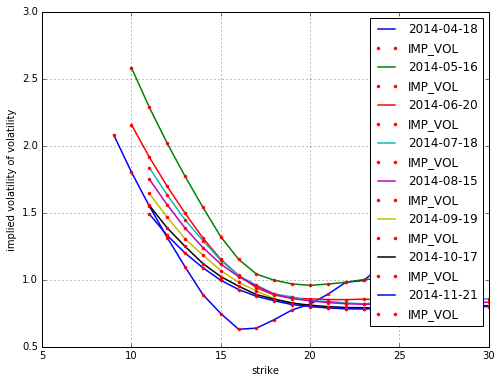

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
      # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'],
             label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()
# tag: vs_imp_vol
# title: Implied volatilities (of volatility) for European call options on the VSTOXX on 31. March 2014

In [17]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

In [18]:
group_data = group_data.sum()
group_data.head()

PRICE   IMP_VOL
MATURITY   STRIKE                 
2014-04-18 9.0      8.85  2.083388
           10.0     7.85  1.804193
           11.0     6.85  1.550283
           12.0     5.85  1.316103
           13.0     4.85  1.097184

In [19]:
group_data.index.levels

FrozenList([[2014-04-18 00:00:00, 2014-05-16 00:00:00, 2014-06-20 00:00:00, 2014-07-18 00:00:00, 2014-08-15 00:00:00, 2014-09-19 00:00:00, 2014-10-17 00:00:00, 2014-11-21 00:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

## Monte Carlo Simulation

In [20]:
from bsm_functions import bsm_call_value
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
bsm_call_value(S0, K, T, r, sigma)

8.0213522351431763

### Pure Python

In [21]:
%run mcs_pure_python.py

European Option Value   7.241
Duration in Seconds     0.023


In [22]:
sum_val = 0.0
for path in S:
    # C-like iteration for comparison
    sum_val += max(path[-1] - K, 0)
C0 = exp(-r * T) * sum_val / I
round(C0, 3)

7.241

### Vectorization with NumPy

In [23]:
v = range(1, 6)
print v

[1, 2, 3, 4, 5]


In [24]:
2 * v

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [25]:
import numpy as np
v = np.arange(1, 6)
v

array([1, 2, 3, 4, 5])

In [26]:
2 * v

array([ 2,  4,  6,  8, 10])

In [27]:
%run mcs_vector_numpy.py

European Option Value   8.037
Duration in Seconds     0.871


In [28]:
round(tpy / tnp1, 2)

0.03

### Full Vectorization with Log Euler Scheme

In [29]:
%run mcs_full_vector_numpy.py

European Option Value   8.166
Duration in Seconds     1.106


### Graphical Analysis

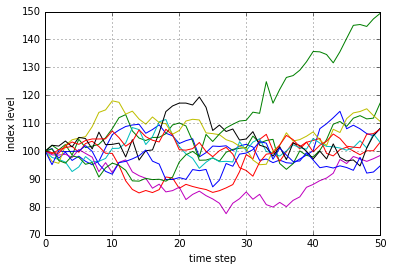

In [30]:
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')
# tag: index_paths
# title: The first 10 simulated index level paths

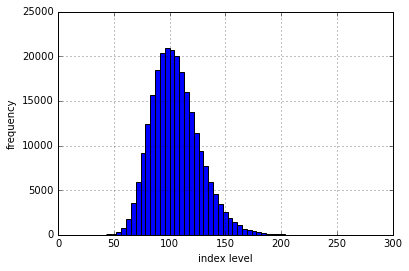

In [31]:
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
# tag: index_histo
# title: Histogram of all simulated end of period index level values

(0, 50000)

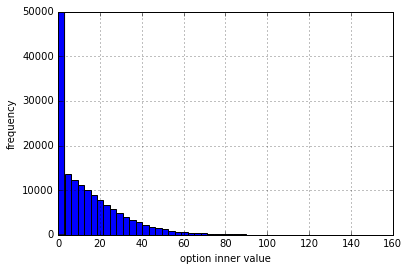

In [32]:
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)
# tag: option_iv_hist
# title: Histogram of all simulated end of period option inner values

In [33]:
sum(S[-1] < K)

133533

## Technical Analysis

In [34]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import pandas as pd


In [35]:
#sp500 = web.DataReader('^GSPC', data_source='yahoo',start='1/1/2000', end='4/14/2014')
#sp500.info()
dates = pd.date_range('20160101',periods=252)
dates

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02',
               '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06',
               '2016-09-07', '2016-09-08'],
              dtype='datetime64[ns]', length=252, freq='D')

In [36]:
gspc = pd.read_csv('data/gspc31.csv',header=None)
#gspc.tail()
#gspc

In [37]:
import numpy  
my_matrix = gspc.as_matrix(columns=None)
#my_matrix

In [38]:
#sp500 = pd.DataFrame(gspc,index=dates,columns=['Open','High','Low','Close','Volume','Adj Close'])
sp500 = pd.DataFrame(my_matrix,index=dates,columns=['Open','High','Low','Close','Volume','Adj Close'])

In [39]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-01 to 2016-09-08
Freq: D
Data columns (total 6 columns):
Open         252 non-null float64
High         252 non-null float64
Low          252 non-null float64
Close        252 non-null float64
Volume       252 non-null float64
Adj Close    252 non-null float64
dtypes: float64(6)
memory usage: 13.8 KB


In [40]:
#sp500[:5]
sp500.tail()
#sp500

,Open,High,Low,Close,Volume,Adj Close
2016-09-04,2129.78,2133.25,2125.53,2126.15,3.922400e+09,2126.15
2016-09-05,2132.23,2140.72,2119.36,2126.41,4.019510e+09,2126.41
2016-09-06,2144.06,2147.13,2132.52,2133.04,4.204830e+09,2133.04
2016-09-07,2136.97,2145.73,2131.59,2139.43,3.775200e+09,2139.43
2016-09-08,2149.72,2151.44,2141.93,2143.16,3.751340e+09,2143.16


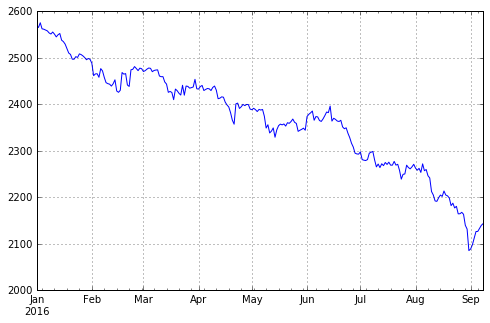

In [41]:
sp500['Close'] = sp500['Close'].astype('float64')

sp500['Close'].plot(grid=True, figsize=(8, 5))
# tag: sp500
# title: Historical levels of the S&P 500 index

In [42]:
sp500['12d'] = np.round(pd.rolling_mean(sp500['Close'], window=12), 2)
sp500['52d'] = np.round(pd.rolling_mean(sp500['Close'], window=52), 2)

In [43]:
sp500[['Close', '12d', '52d']].tail()

,Close,12d,52d
2016-09-04,2126.15,2135.04,2215.44
2016-09-05,2126.41,2130.54,2212.59
2016-09-06,2133.04,2127.95,2209.95
2016-09-07,2139.43,2125.86,2207.33
2016-09-08,2143.16,2123.84,2204.91


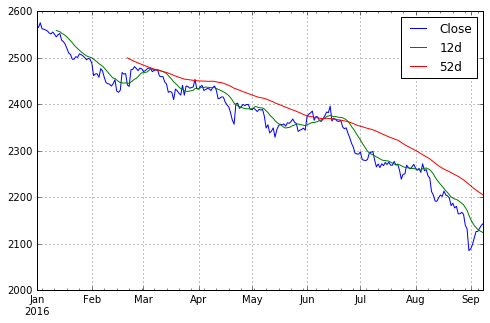

In [44]:
sp500[['Close', '12d', '52d']].plot(grid=True, figsize=(8, 5))
# tag: sp500_trend
# title: The S&P 500 index with 42d and 52d trend lines

In [45]:
sp500['12-52'] = sp500['52d'] - sp500['12d']
sp500['12-52'].tail()


2016-09-04    80.40
2016-09-05    82.05
2016-09-06    82.00
2016-09-07    81.47
2016-09-08    81.07
Freq: D, Name: 12-52, dtype: float64

In [46]:
sp500['12-52'].head()

2016-01-01   NaN
2016-01-02   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-01-05   NaN
Freq: D, Name: 12-52, dtype: float64

In [47]:
#SD = 50
SD = 20
sp500['Regime'] = np.where(sp500['12-52'] > SD, 1, 0)
sp500['Regime'] = np.where(sp500['12-52'] < -SD, -1, sp500['Regime'])
sp500['Regime'].value_counts()

1    134
0    118
Name: Regime, dtype: int64

(-1.1, 1.1)

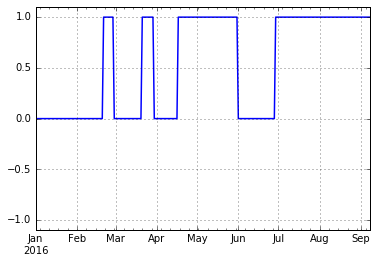

In [48]:
sp500['Regime'].plot(lw=1.5, grid=True)
plt.ylim([-1.1, 1.1])
# tag: sp500_signal
# title: Signal regimes over time

In [49]:
sp500['Market'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

In [50]:
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']

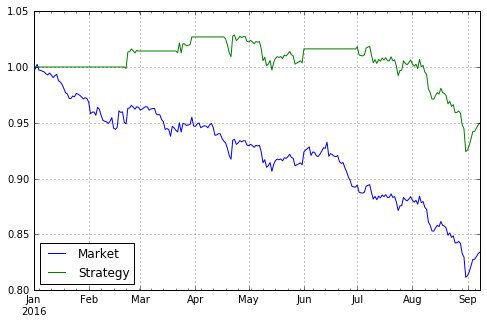

In [51]:
sp500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,
                                                    figsize=(8, 5))
# tag: sp500_wealth
# title: The S&P 500 index vs. investor's wealth

## Conclusions

## Further Reading